In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Device setup: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [22]:
class EventGenerator(nn.Module):
    def __init__(self, latent_dim: int, num_features: int, num_particles: int, num_classes: int, num_statuses: int) -> None:
        super().__init__()
        self.num_particles = num_particles
        self.num_features = num_features
        self.num_classes = num_classes
        self.num_statuses = num_statuses
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_particles * (num_features + num_classes + num_statuses))
        )

    def forward(self, z):
        out = self.fc(z)  # [B, N*(4+classes)]
        out = out.view(z.size(0), self.num_particles, self.num_features + self.num_classes + self.num_statuses)
        features = out[:, :, :self.num_features]
        label_probs = torch.softmax(out[:, :, self.num_features:self.num_features + self.num_classes], dim=2)
        status_probs = torch.softmax(out[:, :, self.num_features + self.num_classes:], dim=2)
        return features, label_probs, status_probs

In [4]:
class EventDiscriminator(nn.Module):
    def __init__(self, num_features: int, num_particles: int, num_classes: int, num_statuses: int):
        super().__init__()
        input_dim = num_features + num_classes + num_statuses
        self.model = nn.Sequential(
            nn.Linear(num_particles * input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features, label_probs, status_probs):
        x = torch.cat([features, label_probs, status_probs], dim=2)
        x = x.view(x.size(0), -1)
        return self.model(x)


In [5]:
# Load the CSV file
df = pd.read_csv("gen_particles_10k_sample.csv")
df.shape, df.columns

((5058758, 11),
 Index(['event', 'pdg_id', 'status', 'px', 'py', 'pz', 'pt', 'eta', 'phi',
        'energy', 'mass'],
       dtype='object'))

In [6]:
df = df[df['status'].isin([1, 2])]
df.shape

(2663564, 11)

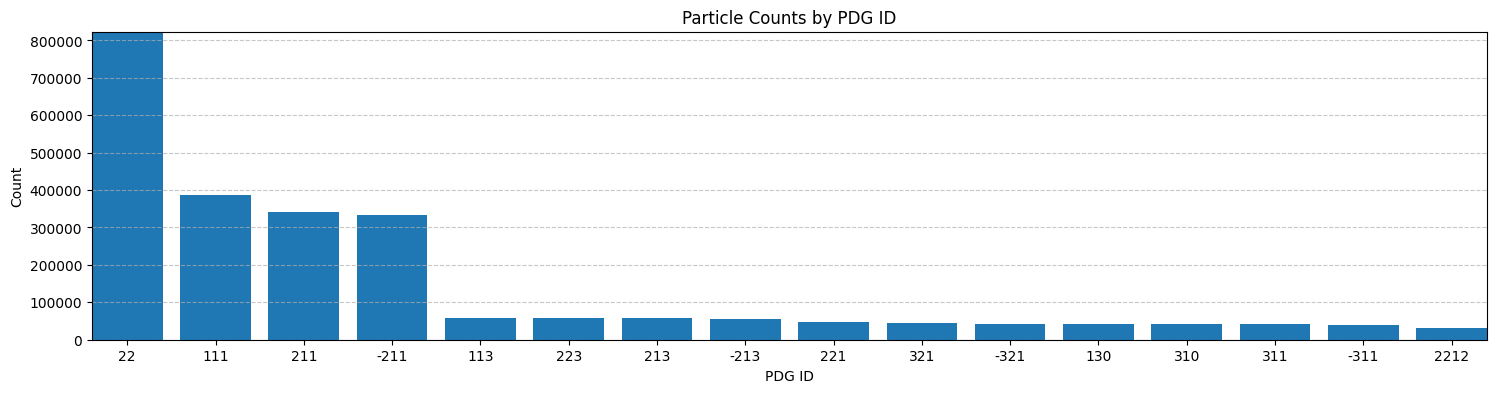

In [23]:
pdg_counts = df['pdg_id'].value_counts()
pdg_counts = pdg_counts[pdg_counts > df.shape[0] * 0.01]

plt.figure(figsize=(18, 4))
plt.bar(pdg_counts.index.astype(str), pdg_counts.values)
plt.xlabel("PDG ID")
plt.ylabel("Count")
plt.title("Particle Counts by PDG ID")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(0)
plt.show()

In [24]:
# df = df[df.status == 1]
df = df[df['pdg_id'].isin(pdg_counts.index.values)]
df.shape

(2447320, 13)

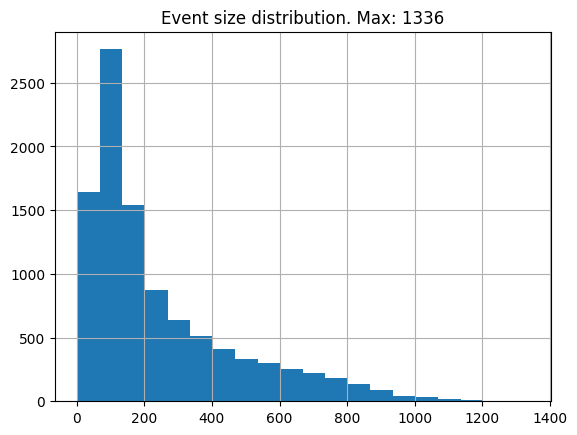

In [43]:
event_counts = df.groupby('event').count()['pdg_id']

event_counts.hist(bins=20)
plt.title("Event size distribution. Max: {}".format(event_counts.max()))
plt.show()

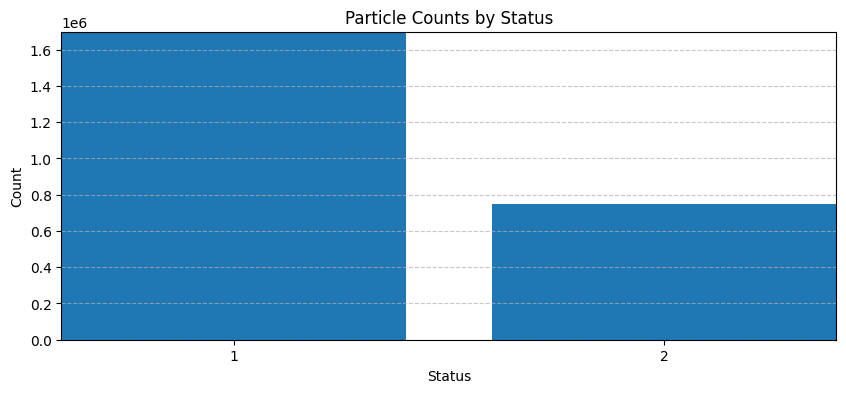

In [28]:
status_counts = df.groupby('status').count()['pdg_id']

plt.figure(figsize=(10, 4))
plt.bar(status_counts.index.astype(str), status_counts.values)
plt.xlabel("Status")
plt.ylabel("Count")
plt.title("Particle Counts by Status")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(0)
plt.show()

In [32]:
# Select relevant columns
features = ['pt', 'eta', 'phi', 'energy']
ptype = 'pdg_id'
status = 'status'

In [33]:
df.columns

Index(['event', 'pdg_id', 'status', 'px', 'py', 'pz', 'pt', 'eta', 'phi',
       'energy', 'mass', 'pdg_label', 'status_label'],
      dtype='object')

In [34]:
label_encoder = LabelEncoder()
df['pdg_label'] = label_encoder.fit_transform(df[target])

In [35]:
status_encoder = LabelEncoder()
df['status_label'] = status_encoder.fit_transform(df[status])

In [36]:
# Normalize feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [44]:
event_groups = df.groupby('event')
len(event_groups)

10000

In [45]:
# Create fixed-size tensors per event, padded with zeros if needed
events = []
for event_id, group in event_groups:
    particles = group[features + ['pdg_label', 'status_label']].values
    padded = np.zeros((event_counts.max(), len(features) + 2))
    padded[:len(particles)] = particles
    events.append(padded)

event_tensor = np.stack(events)  # shape: [num_events, num_particles, num_features + 2]
event_tensor.shape

(10000, 1336, 6)

In [47]:
# Ready for training
print("Number of events:", len(event_tensor))
print("PDG label classes:", label_encoder.classes_)
print("PDG statuses:", status_encoder.classes_)

Number of events: 10000
PDG label classes: [-321 -311 -213 -211   22  111  113  130  211  213  221  223  310  311
  321 2212]
PDG statuses: [1 2]


In [54]:
# Hyperparameters
latent_dim = 21
num_classes = len(label_encoder.classes_)
num_particles = event_counts.max()
num_statuses = len(status_encoder.classes_)
num_epochs = 100
report_each = 10
batch_size = 64

# Models to device
generator = EventGenerator(latent_dim=latent_dim, num_features=len(features), num_classes=num_classes, num_particles=num_particles, num_statuses=num_statuses).to(device)
discriminator = EventDiscriminator(num_features=len(features), num_classes=num_classes, num_particles=num_particles, num_statuses=num_statuses).to(device)

In [55]:
# Loss and optimizers
adversarial_loss = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [56]:
event_tensor = torch.tensor(event_tensor, dtype=torch.float32).to(device)
dataloader = DataLoader(event_tensor, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_12915/2603283904.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_tensor = torch.tensor(event_tensor, dtype=torch.float32).to(device)


In [58]:
loss_list = []

# Training loop
for epoch in range(1, num_epochs + 1):
    for i, real_event in enumerate(dataloader):
        real_event = real_event.to(device)

        # Split real_event into features, labels and statuses
        real_features = real_event[:, :, :len(features)]
        real_labels = F.one_hot(real_event[:, :, len(features)].long(), num_classes).float()
        real_statuses = F.one_hot(real_event[:, :, len(features) + 1].long(), num_statuses).float()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real data
        valid = torch.ones(real_event.size(0), 1, device=device)
        real_loss = adversarial_loss(discriminator(real_features, real_labels, real_statuses), valid)

        # Fake data
        z = torch.randn(real_event.size(0), latent_dim, device=device)
        fake_features, fake_labels, fake_statuses = generator(z)
        fake = torch.zeros(real_event.size(0), 1, device=device)
        fake_loss = adversarial_loss(discriminator(fake_features, fake_labels, fake_statuses), fake)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(real_event.size(0), latent_dim, device=device)
        gen_features, gen_labels, gen_statuses = generator(z)
        g_loss = adversarial_loss(discriminator(gen_features, gen_labels, gen_statuses), valid)

        g_loss.backward()
        optimizer_G.step()

    if epoch % report_each == 0 or epoch in (1, num_epochs):
        print(f"[Epoch {epoch}/{num_epochs}] D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

[Epoch 1/100] D loss: 0.0002 | G loss: 10.8230
[Epoch 10/100] D loss: 0.0001 | G loss: 13.3700
[Epoch 20/100] D loss: 0.0019 | G loss: 14.2816
[Epoch 30/100] D loss: 0.0000 | G loss: 15.3517
[Epoch 40/100] D loss: 0.0013 | G loss: 10.4335
[Epoch 50/100] D loss: 0.0002 | G loss: 14.1086
[Epoch 60/100] D loss: 0.0000 | G loss: 16.6829
[Epoch 70/100] D loss: 0.0000 | G loss: 24.2730
[Epoch 80/100] D loss: 0.0000 | G loss: 14.8233
[Epoch 90/100] D loss: 0.2434 | G loss: 18.8140
[Epoch 100/100] D loss: 0.0071 | G loss: 16.5957


In [59]:
with torch.no_grad():
    z = torch.randn(100, latent_dim, device=device)
    f, l, s = generator(z)
    f = f.cpu().numpy()
    gen_labels = torch.argmax(l, dim=1).cpu().numpy()

ValueError: x must have 2 or fewer dimensions

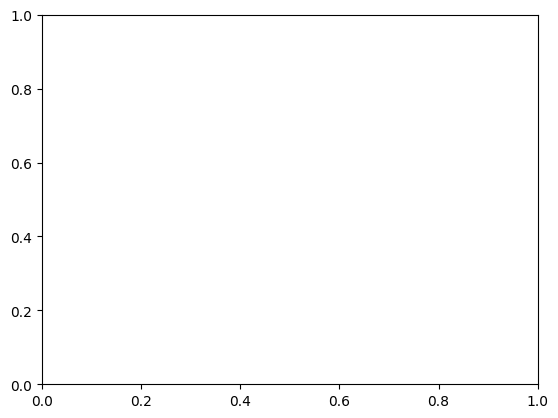

In [60]:
for i, fn in enumerate(features):
    plt.hist([X_tensor[:, i], f[:, i]], bins=100, label=["Real","Fake"], density=True, histtype='step')
    plt.legend()
    plt.title(f"Generated {fn}")
    plt.show()

In [ ]:
gen_part_types = label_encoder.inverse_transform(gen_labels)
np.unique(gen_part_types, return_counts=True)

In [ ]:
real_counts = np.array([(df['pdg_id'].values == pid).sum() for pid in label_encoder.classes_])
gen_counts = np.array([(gen_part_types == pid).sum() for pid in label_encoder.classes_])

In [ ]:
x = np.arange(len(label_encoder.classes_))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, real_counts, width, label='Training')
plt.bar(x + width/2, gen_counts, width, label='Generated')

plt.xlabel('PDG ID')
plt.ylabel('Count')
plt.title('PDG ID Distribution: Training vs Generated')
plt.xticks(ticks=x, labels=label_encoder.classes_.astype(str), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import torch
torch.randn(1).to("cuda")